In [29]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nni
import pickle
import json
from scipy.stats import entropy
from model import Inputs, build_network, run_once

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})  # font='CMU Serif',

In [26]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical):
    # return np.abs(simulated - empirical)
    print('simulated', simulated)
    print('empirical', empirical)
#     loss = np.sum(np.abs(simulated - empirical))
#     loss = 1 - entropy(simulated, empirical)
    loss = chi_squared_distance(simulated, empirical)
    print('loss', loss)
    return loss

def run_group(params, deltaPs=[0.1, 0.2, 0.4]):
    dfs = []
    columns = ('agent', 'pid', 'dP', 'accuracy', 'speed', 'loss')
    pids = list(params.keys())
    pids = [int(pid) for pid in pids]
    for pid in pids:
        args = params[str(pid)]
        T = args['T']
        m = args['m']
        tau = args['tau']
        delta = args['delta']
        seed = args['seed']
        with open('data/pids.pkl', 'rb') as f:
            studyIDs = pickle.load(f)
        participant_ID = studyIDs[pid]

        for dP in deltaPs:
            print(f"pid={pid}, dP={dP}")
            empirical = pd.read_pickle("data/empirical.pkl").query("maxSamples==12 & delta==@dP & participant_id==@participant_ID")
            empirical_cues = empirical['cues'].to_numpy()
            empirical_accuracy = empirical['correct'].to_numpy()
            empirical_hist = np.histogram(empirical['cues'].to_numpy(), bins=np.arange(0, 27, 3))[0]
            nTrials = empirical.shape[0]
            simulated_cues = []
            simulated_accuracy = []
            inputs = Inputs(deltaP=dP, maxCues=12, seed=pid, empirical=empirical)
            net = build_network(inputs, seed=seed, T=T, m=m, tau=tau, delta=delta)
            for trial in range(nTrials):
                net.inputs.set_AB(trial=trial)
                is_correct, cues_sampled = run_once(net)
                simulated_cues.append(cues_sampled)
                simulated_accuracy.append(1.0*is_correct)
            simulated_hist = np.histogram(simulated_cues, bins=np.arange(0, 27, 3))[0]
            total_loss = get_loss(simulated_hist, empirical_hist)
            dfs.append(pd.DataFrame([['model', pid, dP, 100*np.mean(simulated_accuracy), np.mean(simulated_cues), total_loss]], columns=columns))
            dfs.append(pd.DataFrame([['human', pid, dP, 100*np.mean(empirical_accuracy), np.mean(empirical_cues), 0]], columns=columns))

        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/group_behavior.pkl")
    
def plot():
    data = pd.read_pickle(f"data/group_behavior.pkl")

    # fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True, sharey=True)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((7.08, 3)), sharex=True, sharey=True)
    sns.regplot(data=data.query("agent=='human' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][0])
    sns.regplot(data=data.query("agent=='human' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][1])
    sns.regplot(data=data.query("agent=='human' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[0], ax=axes[0][2])
    sns.regplot(data=data.query("agent=='model' & dP==0.4"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][0])
    sns.regplot(data=data.query("agent=='model' & dP==0.2"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][1])
    sns.regplot(data=data.query("agent=='model' & dP==0.1"), x='speed', y='accuracy', scatter_kws={'s': 10}, line_kws={'color': 'black'}, color=palette[1], ax=axes[1][2])
    # sns.regplot(data=sat_data.query("agent=='human' & dP==0.4"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[2], ax=axes[0])
    # sns.regplot(data=sat_data.query("agent=='human' & dP==0.2"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[0], ax=axes[1])
    # sns.regplot(data=sat_data.query("agent=='human' & dP==0.1"), x='mean cues', y='mean correct', scatter=False, line_kws={'color': 'gray'}, color=palette[1], ax=axes[2])
    sns.scatterplot(x=[0],y=[0], color=palette[0], label=f"Human Data", ax=axes[0][0])
    sns.scatterplot(x=[0],y=[0], color=palette[1], label=f"Model Data", ax=axes[1][0])
    axes[0][0].set(ylabel='Mean Accuracy', xlabel=None, title="Easy", ylim=((50, 110)), yticks=((50, 75, 100)))
    axes[0][1].set(ylabel=None, xlabel=None, title="Moderate")
    axes[0][2].set(ylabel=None, xlabel=None, title="Hard", xticks=np.arange(0, 27, 3), xlim=((0, 24)))
    axes[1][0].set(ylabel='Mean Accuracy', xlabel='Mean Cues', ylim=((50, 110)), yticks=((50, 75, 100)))
    axes[1][1].set(ylabel=None, xlabel='Mean Cues')
    axes[1][2].set(ylabel=None, xlabel='Mean Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
    axes[0][0].legend(loc='lower right')
    axes[1][0].legend(loc='lower right')
    plt.tight_layout()
    fig.savefig(f"plots/group_behavior.svg")
    fig.savefig(f"plots/group_behavior.png", dpi=600)

In [31]:
params = {
    '1': {'delta': 0.86, 'm': 0.12, 'seed': 20, 'T': 0.36, 'tau': 0.03},
    '38': {'delta': 0.21, 'm': 0.22, 'seed': 97, 'T': 0.74, 'tau': 0.05}
}

run_group(params)

pid=1, dP=0.1
simulated [ 0  5 23 11  5  3  1  0]
empirical [ 0  5 21 12  6  3  1  0]
loss 0.22529644268774704
pid=1, dP=0.2
simulated [ 0  7 17 12 10  2  0  0]
empirical [ 0  3 23 15  4  3  0  0]
loss 5.604761904761905
pid=1, dP=0.4
simulated [ 0  9 26  8  4  1  0  0]
empirical [ 0  6 24 14  3  1  0  0]
loss 2.459220779220779
pid=38, dP=0.1
simulated [0 0 1 5 5 3 2 8]
empirical [1 0 0 6 5 3 2 8]
loss 2.090909090909091
pid=38, dP=0.2
simulated [0 0 3 4 8 6 1 3]
empirical [0 1 6 3 2 4 3 7]
loss 8.742857142857144
pid=38, dP=0.4
simulated [ 0  0  3 12  5  4  1  0]
empirical [0 2 7 8 3 2 1 2]
loss 7.566666666666667


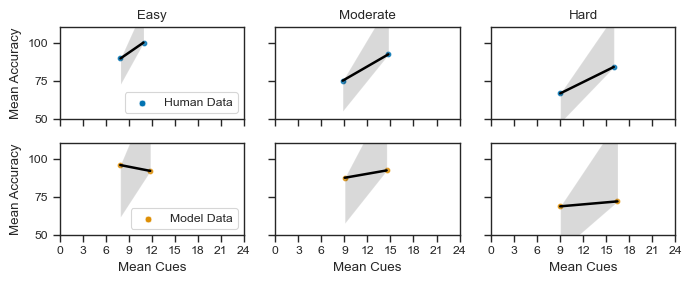

In [32]:
plot()